In [1]:
## Ran notebook multiple times to obtain txt and csv files for separate CEO's

# Library Imports
import tweepy
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import Blobber
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import config
import sys
import jsonpickle
import os
from unidecode import unidecode

plt.style.use('fivethirtyeight')

In [2]:
# Set variables for API keys and tokens
ak = config.apiKey
ask = config.apiSecretKey

## Additional tokens if needed ##
    # at = config.accessToken
    # ats = config.accessTokenSecret
## --------------------------- ##

# Create authentication object
authenticate = tweepy.AppAuthHandler(ak, ask)
authenticate.secure = True

# Make the API call wait when it hits the
# rate limit then continue upon expiry of the window 
api = tweepy.API(authenticate, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Set condition for failed authentication
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [3]:
# source: https://bit.ly/2WSO8El

searchQuery = 'Jack Dorsey'
retweet_filter = '-filter:retweets'
tweetsPerQry = 100
fName = 'DorseyTweets.txt'
sinceId = None

max_id = -1
maxTweets = 50000

tweetCount = 0

print(f"Downloading max {maxTweets} tweets")

with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en')
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                # only use tweet._json rather that tweet.json['text'] to get full json for each tweet
                f.write(jsonpickle.encode(tweet._json['text'],
                                          unpicklable=False) + '\n') # Only pull tweet text to minimize file size
            tweetCount += len(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print (f"Downloaded {tweetCount} tweets, Saved to {fName}")

No more tweets found
Downloaded 3187 tweets, Saved to DorseyTweets.txt


In [28]:
# Create dataframe containing tweets
df = pd.read_fwf('DorseyTweets.txt', sep = '\n', header = None)

df.columns = ['Tweets']

# Clean tweets
def cleanTxt(text):
    
    text = re.sub(r'@[A-Za-z0-9]+','',text) # Remove @mentions
    text = re.sub(r'#','',text) # Remove '#' symbols
    text = re.sub(r'RT[\s]+','',text) # Remove retweets
    text = re.sub(r'https?:\/\/\S+','',text) # Remove hyperlink
    text = re.sub(r':','',text) # Remove colons
    text = re.sub(r'\\u[A-Za-z0-9]+','',text) # Remove unicode
    text = re.sub(r'"','',text) # Remove quotation marks
    text = re.sub(r'Jack','',text) # Remove Elon
    text = re.sub(r'jack','',text) # Remove elon
    text = re.sub(r'Dorsey','',text) # Remove Musk
    text = re.sub(r'dorsey','',text) # Remove musk
    return text

df['Tweets'] = df['Tweets'].apply(cleanTxt)

df

,Tweets
0,&amp; Twitter TWITTER*&amp; All*&amp; All ALL&...
1,We've known this for years.\n\n is a jerk cum ...
2,has a secret ban against Trump supporters - ...
3,Please investigation as soon as possible about...
4,DEAR JACK DORSEY WHY THE FUCK DO MY IMPRESSION...
...,...
3182,Twitter CEO donates $3M to fund universal ba...
3183,&gt;time to move on\nyeah let's not hold acc...
3184,quite possibly misled Congress when he said ...
3185,"next in the news, works for the CCP."


In [29]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Compute negative, neutral and positive analysis

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

df.insert(0,'CEO','Jack Dorsey')

df

,CEO,Tweets,Subjectivity,Polarity,Analysis
0,Jack Dorsey,&amp; Twitter TWITTER*&amp; All*&amp; All ALL&...,0.000000,0.000000,Neutral
1,Jack Dorsey,We've known this for years.\n\n is a jerk cum ...,0.000000,0.000000,Neutral
2,Jack Dorsey,has a secret ban against Trump supporters - ...,0.700000,-0.400000,Negative
3,Jack Dorsey,Please investigation as soon as possible about...,1.000000,0.000000,Neutral
4,Jack Dorsey,DEAR JACK DORSEY WHY THE FUCK DO MY IMPRESSION...,0.600000,-0.400000,Negative
...,...,...,...,...,...
3182,Jack Dorsey,Twitter CEO donates $3M to fund universal ba...,0.208333,0.166667,Positive
3183,Jack Dorsey,&gt;time to move on\nyeah let's not hold acc...,0.250000,0.250000,Positive
3184,Jack Dorsey,quite possibly misled Congress when he said ...,1.000000,0.000000,Neutral
3185,Jack Dorsey,"next in the news, works for the CCP.",0.000000,0.000000,Neutral


In [30]:
df.to_csv('DorseyTweets.csv', encoding='utf-8', index=False)

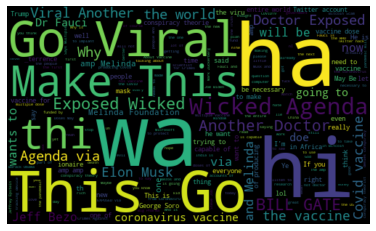

In [27]:
# Plot Word Cloud
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [7]:
## Print positive tweets

# j = 1
# sortedDF = df.sort_values(by=['Polarity'], ascending=False)
# for i in range(0, sortedDF.shape[0]):
#     if (sortedDF['Analysis'][i] == 'Positive'):
#         print(str(j) + '. ' + sortedDF['Tweets'][i] + '\n')
#         j+=1

In [8]:
## Plot polarity and subjectivity

# plt.figure(figsize = (8,6))

# for i in range(0, df.shape[0]):
#     plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue', alpha = 0.5)
    
# plt.title('Sentiment Analysis')
# plt.xlabel('Polarity')
# plt.ylabel('Subjectivity')
# plt.show()

In [9]:
# Get percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
ptweetspercent = round((ptweets.shape[0] / df.shape[0]*100), 1)
print(f'Positive Tweet %: {ptweetspercent}')

# Get percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
ntweetspercent = round((ntweets.shape[0] / df.shape[0]*100), 1)
print(f'Negative Tweet %: {ntweetspercent}')

# Get percentage of neutral tweets
rtweets = df[df.Analysis == 'Neutral']
rtweets = rtweets['Tweets']
rtweetspercent = round((rtweets.shape[0] / df.shape[0]*100), 1)
print(f'Neutral Tweet %: {rtweetspercent}')

Positive Tweet %: 27.3
Negative Tweet %: 16.4
Neutral Tweet %: 56.3


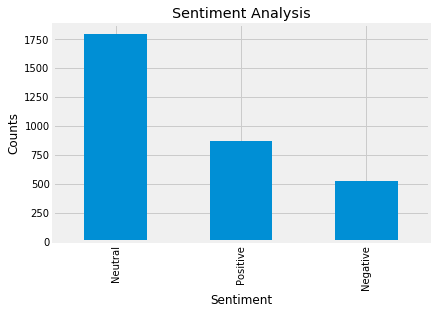

In [10]:
# Show value counts

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

df['Analysis'].value_counts().plot(kind='bar')
plt.show()

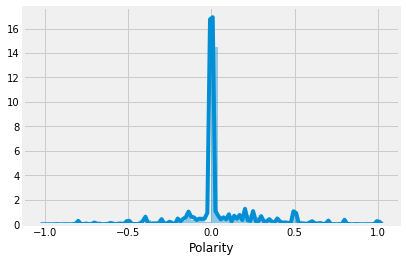

In [11]:
sns.distplot(df['Polarity'])